In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import unicodedata

In [2]:
datetime.now()

datetime.datetime(2020, 3, 26, 10, 7, 56, 146273)

In [3]:
url = 'https://www.health.gov.au/news/health-alerts/novel-coronavirus-2019-ncov-health-alert/coronavirus-covid-19-current-situation-and-case-numbers'
content = requests.get(url).content

In [4]:
soup = BeautifulSoup(content)
data = soup.findAll(text=re.compile('As .+')) + \
        soup.findAll(text=re.compile('.*(?:(Australian Capital Territory)|(Queensland)|(Victoria)|(New South Wales)|(South Australia)|(Western Australia)|(Northern Territory)|(Tasmania)|(Diamond Princess))')) 
data = ' '.join(data)
data

'As at 3:00pm on 26\xa0March 2020, there have been\xa0 Australian Capital Territory New South Wales Northern Territory Queensland South Australia Tasmania Victoria Western Australia **Includes Diamond Princess repatriation cases: Qld (3), SA (1), Vic (4), WA (2, including 1 death)'

In [5]:
cases_str = unicodedata.normalize("NFKD", data)

In [6]:
cases_str

'As at 3:00pm on 26 March 2020, there have been  Australian Capital Territory New South Wales Northern Territory Queensland South Australia Tasmania Victoria Western Australia **Includes Diamond Princess repatriation cases: Qld (3), SA (1), Vic (4), WA (2, including 1 death)'

In [7]:
date_time_str = re.search('As .+ (\d+ \w+ 202\d)' ,cases_str).group(1)
date_time_str

'26 March 2020'

In [8]:
data_date_time = datetime.strptime(date_time_str, '%d %B %Y').strftime('%Y-%m-%d')
data_date_time

'2020-03-26'

In [9]:
# m = re.search('there were (\d+) confirmed cases', cases_str)
# australia = int(m.group(1))
# australia

In [10]:
# m = re.search('(\d+) in New South Wales', cases_str)
# nsw = int(m.group(1))


In [11]:
# m = re.search('(\d+) in Victoria', cases_str)
# victoria = int(m.group(1))

In [12]:
# m = re.search('(\d+) in South Australia', cases_str)
# sa = int(m.group(1))

In [13]:
# m = re.search('(\d+) in Queensland', cases_str)
# qld = int(m.group(1))

In [14]:
# m = re.search('(\d+) in Tasmania', cases_str)
# tas = int(m.group(1))


In [15]:
# m = re.search('(\d+) in .* Australian Capital Territory', cases_str)
# act = int(m.group(1))



In [16]:
# m = re.search('(\d+) in Northern Territory', cases_str)
# nt = int(m.group(1))


In [17]:
# m = re.search('(\d+) .* Diamond Princess', cases_str)
# wa = int(m.group(1))


### Dataframe

In [18]:
df1 = pd.read_html(url)[0]
df1 = df1.set_index(0).T
df1.insert(0, 'date', data_date_time)
df1 = df1.drop(['Location'], axis=1)
df = df1.rename(columns={
    'Total**':'australia',
    'Australian Capital Territory':'act',
    'New South Wales':'nsw',
    'Queensland':'qld',
    'South Australia':'sa',
    'Tasmania':'tas',
    'Victoria':'victoria',
    'Western Australia':'wa',
    'Northern Territory':'nt',
})

In [19]:
df.drop(columns=df.columns[-1], inplace=True)
df

,date,act,nsw,nt,qld,sa,tas,victoria,wa,australia
1,2020-03-26,53,1219,8,493,235,40,520,231,2799


In [20]:
assert int(df['australia'])>0

In [21]:
df

,date,act,nsw,nt,qld,sa,tas,victoria,wa,australia
1,2020-03-26,53,1219,8,493,235,40,520,231,2799


### Save to file

In [22]:
from pathlib import Path
csv_file = '../data/australia-cases.csv'

if Path(csv_file).exists():
    # read out the old data
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['date'], inplace=True)

In [23]:
df.sort_values(by=['date'], inplace=True)
df.to_csv(csv_file, index=False)
df

,date,act,nsw,nt,qld,sa,tas,victoria,wa,australia
0,2020-02-04,NaN,4,NaN,2,2,NaN,4,NaN,12
1,2020-02-05,NaN,4,NaN,3,2,NaN,4,NaN,13
2,2020-02-06,NaN,4,NaN,4,2,NaN,4,NaN,14
3,2020-02-07,NaN,4,NaN,5,2,NaN,4,NaN,15
4,2020-02-08,NaN,4,NaN,5,2,NaN,4,NaN,15
5,2020-02-09,NaN,4,NaN,5,2,NaN,4,NaN,15
6,2020-02-10,NaN,4,NaN,5,2,NaN,4,NaN,15
7,2020-02-11,NaN,4,NaN,5,2,NaN,4,NaN,15
8,2020-02-12,NaN,4,NaN,5,2,NaN,4,NaN,15
9,2020-02-13,NaN,4,NaN,5,2,NaN,4,NaN,15


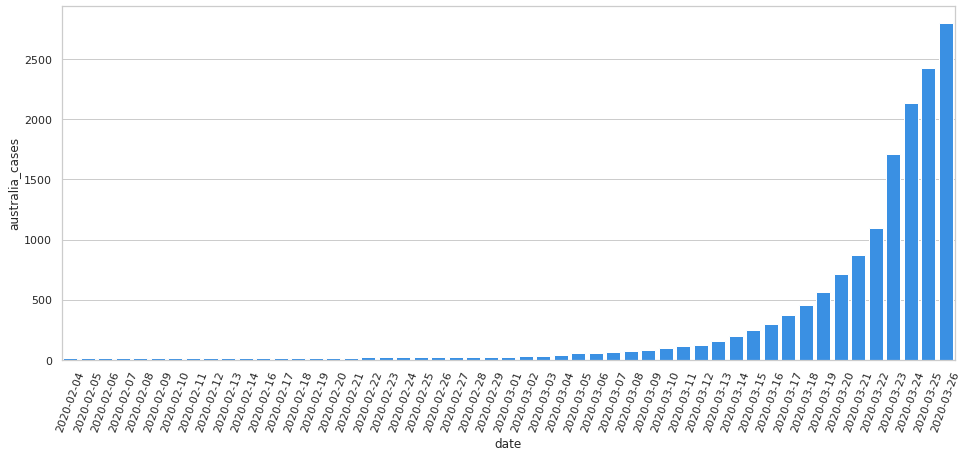

In [24]:
# plot
df['australia_cases']= df['australia'].apply(lambda x: int(x))

import seaborn as sns


sns.set(rc={'figure.figsize':(16,6.5)})
sns.set(style="whitegrid")


bar_chart = sns.barplot(x='date', y='australia_cases', color='dodgerblue', data=df)
bar_chart.tick_params(axis='x', labelrotation=70)


In [25]:
png_file = '../images/australia-cases.png'
bar_chart_fig = bar_chart.get_figure()
bar_chart_fig.savefig(png_file)
